$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5.1: Control a Marble with Reinforcement Learning

*Sarah Houlton*

## Overview

In this assignment, you will be modifying the reinforcement learning code used to solve the dynamic marble problem.  You will be solving a more complex version of the marble problem in which a goal position is specified as a new state variable.

Start with the code in the notebook for lecture notes 17.

## Requirements

Use the plotting code from Lecture 17 to show your results.  In addition to those plots, create nine additional versions of the lower-right plot for goal positions at 1, 2, 3, 4, 5, 6, 7, 8, and 9.

The general approach is as follows.

The state of the marble is given by $(x_t,
\dot{x_t})$.  In this new problem, the state will be $(x_t,
\dot{x_t}, g_t)$, where $g_t$ is the goal at time $t$.  Modify the
`initialState` function to randomly choose a new goal $g_t$ to be a
random value between 1 and 9. Modify `nextState` so that the goal
value remains the same in the new state as it was in the old state.  You will also
have to modify the reinforcement function to depend on the
current $g_t$ value.

Many of the figures will still make sense.  Include them in your
report.  The contour (and surface)
plots and the plot that tests the marble's behavior for various intial
positions must be produced for a single value of the goal.  Generate
several versions of the contour and surface plots and the test plots for goals of 1, 5, and 9 to show how
they vary when the goal is varied.

Experiment with values of the parameters, such as the number of trials, number of
steps per trial, number of SCG iterations in each train call, number of hidden units, finalEpsilon, and gamma.  Try
to find values that result in a trained network that controls the
marble well for most of the goal settings.
Discuss your experience with finding good parameter values.

Discuss the changes you tried and the results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
import neuralnetworks as nn   # from notes 09

In [2]:
import copy

actions = (-1, 0, 1)   # Possible actions

def reinforcement(s, s1):
    goal = s[2]
    return 0 if abs(s1[0]-goal) < 1 else -1
    # return -abs(s1[0] - goal)

def initialState(goal=None):
    if(goal == None):
        goal = random.randint(0,9)
    return np.array([10 * np.random.random_sample(), 0.0, goal])

def nextState(s, a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = [0,0, s[2]]
    elif s[0] > 10:
        s = [10,0, s[2]]
    return s

In [3]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state, a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    Q = nnetQ.use(np.hstack((state, action)).reshape((1, -1)))
    return action, Q

In [4]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon, goal = None):

    X = np.zeros((numSamples, nnet.n_inputs))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF(goal)
    s = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)

    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s, a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plotStatus(net, trial, epsilonTrace, rtrace, g = 5):
    plt.subplot(4, 3, 1)
    plt.plot(epsilonTrace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
    plt.subplot(4, 3, 2)
    plt.plot(X[:, 0])
    plt.plot([0, X.shape[0]], [5, 5], '--', alpha=0.5, lw=5)
    plt.ylabel('$x$')
    plt.ylim(-1, 11)
    qs = net.use(np.array([[s, 0, g, a] for a in actions for s in range(11)]))
    plt.subplot(4, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2, 'Policy for Zero Velocity')
    plt.axis('off')
    plt.subplot(4, 3, 4)
    plt.plot(rtrace[:trial + 1], alpha=0.5)
    binSize = 20
    if trial + 1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial / binSize) * binSize].reshape((int(trial / binSize), binSize)),
                           axis=1)
        plt.plot(np.arange(1, 1 + int(trial / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')
    plt.subplot(4, 3, 5)
    plt.plot(X[:, 0], X[:, 1])
    plt.plot(X[0, 0], X[0, 1], 'o')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([g -1, g + 1], [-5, -5], [5, 5], color='red', alpha=0.3)
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.subplot(4, 3, 6)
    net.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])
    
    plt.subplot(4, 3, 7)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = net.use(np.array([[xsflat[i], ysflat[i], g, a] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
    plt.subplot(4, 3, 8)
    acts = np.array(actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    s = plt.subplot(4, 3, 10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, qsmax, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    s = plt.subplot(4, 3, 11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, acts, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    plt.tight_layout()

In [6]:
def testIt(Qnet, nTrials, nStepsPerTrial, g = 5):
    xs = np.linspace(0, 10, nTrials)
    plt.subplot(4, 3, 12)
    for x in xs:
        s = [x, 0, g] # 0 velocity
        xtrace = np.zeros((nStepsPerTrial, 3))
        for step in range(nStepsPerTrial):
            a,_ = epsilonGreedy(Qnet, s, actions, 0.0) # epsilon = 0
            s = nextState(s, a)
            xtrace[step, :] = s
        plt.plot(xtrace[:, 0], xtrace[:, 1])
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.plot([g, g], [-5, 5], '--', alpha=0.5, lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [7]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

### Testing all goal positions

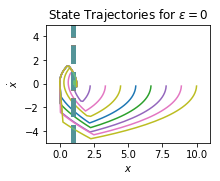

In [8]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 1)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 1)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

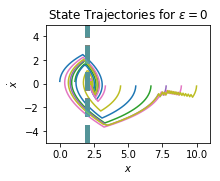

In [9]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 2)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 2)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

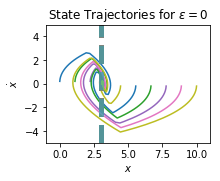

In [10]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 3)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 3)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

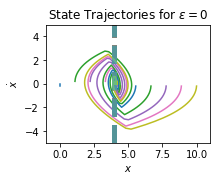

In [11]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 4)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 4)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

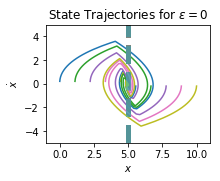

In [12]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 5)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 5)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

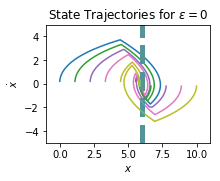

In [13]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 6)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 6)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

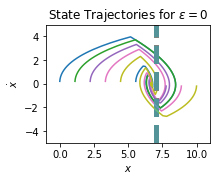

In [14]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 7)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 7)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

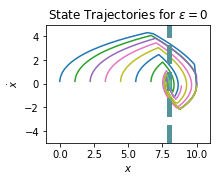

In [15]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 8)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 8)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

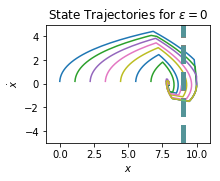

In [16]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 9)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        testIt(nnetQ, 10, 500, 9)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

### Goal == 5

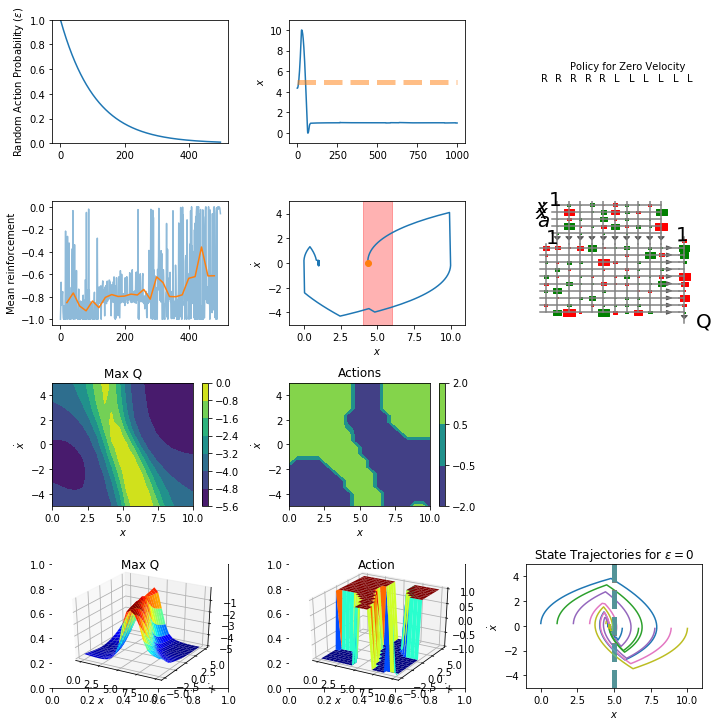

In [18]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

### Goal == 1

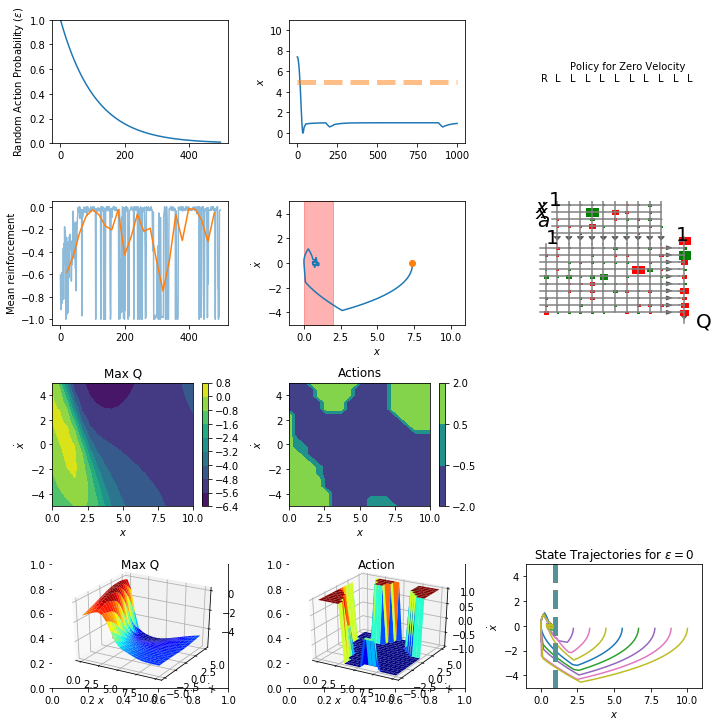

In [19]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 1)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, 1)
        testIt(nnetQ, 10, 500, 1)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

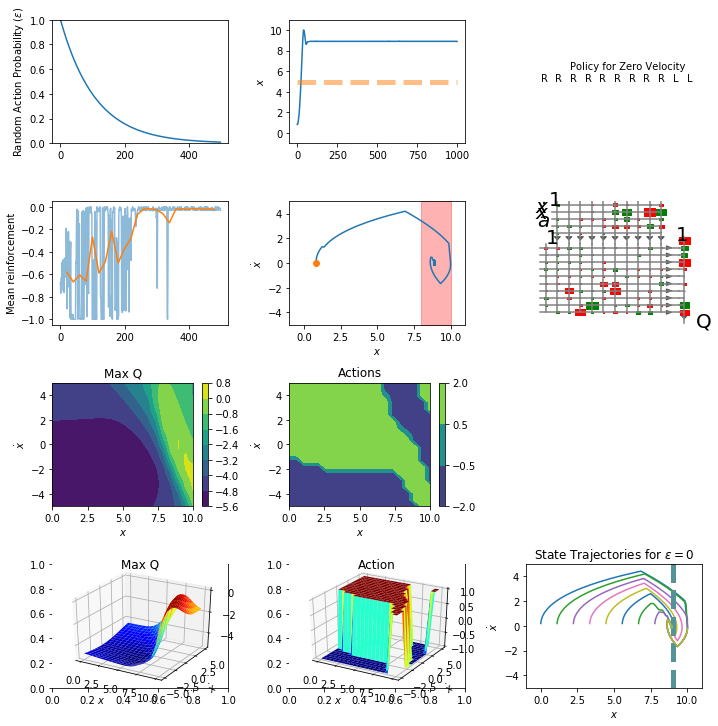

In [20]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon, 9)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace, 9)
        testIt(nnetQ, 10, 500, 9)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

### Testing with new parameters

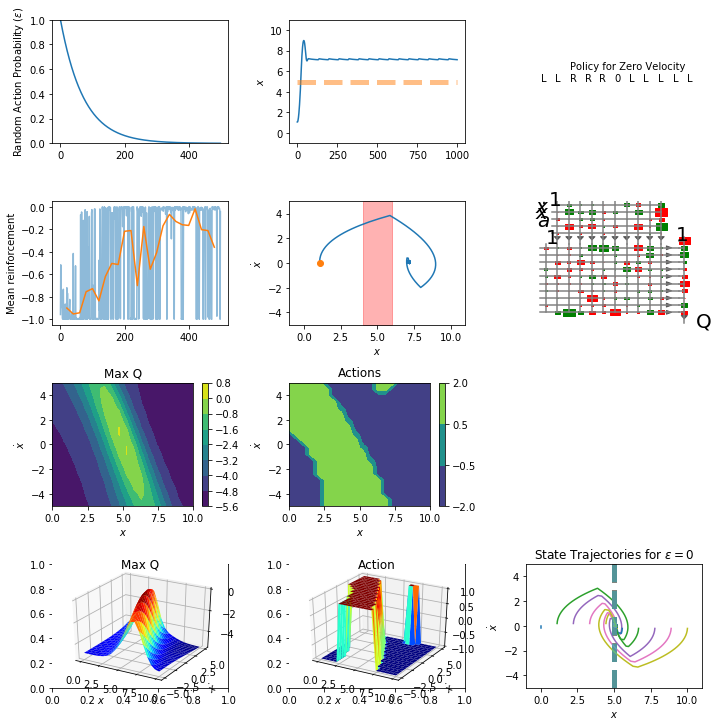

In [21]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.001   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

A smaller epsilon value seems to give marginally better results, but nothing drastic.

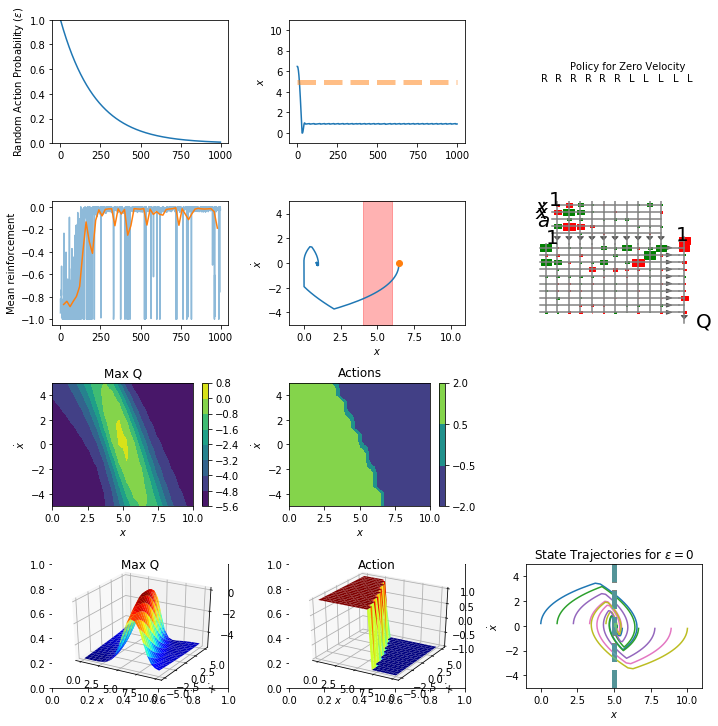

In [22]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 1000         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

A larger number of trials made a large difference, and the final plots behave much better.

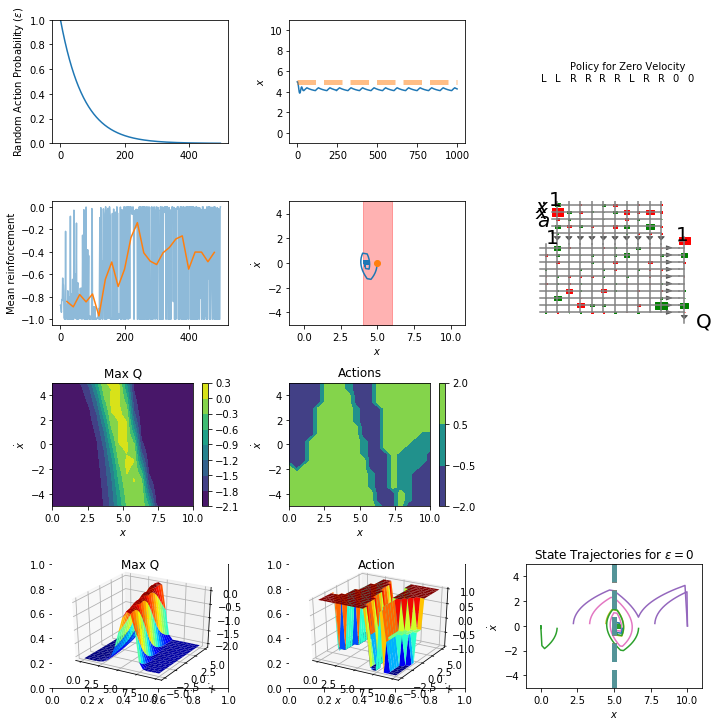

In [23]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.5           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.001   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(4, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 5, 0], [2, 2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)

Reducing the gamma value made the results much worse and somewhat unpredictable.

## Grading

Download [A5grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A5grader.zip) and extract A5grader.py from it. Run the code in the following cell to demonstrate an example grading session. 

In [24]:
%run -i A5grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Houlton-A1.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

######################################################################
Testing

s = initialState(6.6)


--- 20/20 points. initialState correctly returns goal of 6.6 as third component.

######################################################################
Testing

r = reinforcement(np.array([2.8, 2, 3]), np.array([3.6, 1, 3]))


--- 20/20 points. reinforcement correctly returns 0.

######################################################################
Testing

r = reinforcement(np.array([7., 2., 3.]), np.array([8., 1., 3.]))


--- 20/20 points. reinforcement correctly returns -1.

######################################################################
Testing

s_next = nextState(np.array([1.0, 0.0, 7.0]), 1.0)



--- 10/10 points. nextState correctl

<Figure size 432x288 with 0 Axes>